In [32]:
import pandas as pd
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
import numpy as np
from numpy import array

import seaborn as sns
import matplotlib.pyplot as plt
import datetime

import statsmodels.api as sm
from statsmodels.formula.api import ols

import scipy
from scipy import stats,interpolate
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import skew,kurtosis,describe,variation,shapiro
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.special import kl_div
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

import optuna
from optuna.samplers import TPESampler
from optuna.integration import XGBoostPruningCallback
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import GridSearchCV,cross_validate
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression,LinearRegression,Ridge,Lasso,ElasticNet
from sklearn.model_selection import train_test_split,cross_val_score, StratifiedKFold, KFold 
from sklearn.ensemble import IsolationForest,GradientBoostingRegressor,HistGradientBoostingRegressor,AdaBoostRegressor,RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from mlxtend.regressor import StackingRegressor,StackingCVRegressor
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler,RobustScaler,Binarizer

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

import warnings 
warnings.filterwarnings(action='ignore')

In [2]:
def describex(data):
        data = pd.DataFrame(data)
        stats = data.describe()
        skewness = data.skew()
        kurtosis = data.kurtosis()
        skewness_df = pd.DataFrame({'skewness':skewness}).T
        kurtosis_df = pd.DataFrame({'kurtosis':kurtosis}).T
        Appended_Stats = pd.concat([stats,skewness_df,kurtosis_df],axis=0)
        return Appended_Stats

    
def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)    

def SMAPE(y, pred):
    return np.mean((np.abs(y-pred))/(np.abs(y) + np.abs(pred)))

def NMAE(y, pred):
    mae = np.mean(np.abs(y-pred))
    score = mae / np.mean(np.abs(y))
    return score
    

def Analysis(Input_Data):
    
    Stats = describex(Input_Data)
    
    #sns.set(font_scale=1.0)
    #fig, ax = plt.subplots(45,4, figsize=(25, 200)) # 데이터 개수에 따라 플롯 형태 변경 가능 
    #fig.subplots_adjust(hspace = .4, wspace=.3, )
    #ax = ax.ravel()

    #for i in range(len(Input_Data.columns)):
    #    ax[i] = Input_Data.iloc[:,i].plot(kind='hist', ax=ax[i],color='blue',alpha=0.5,secondary_y=True,bins=5)
    #    plt.grid(True)
    #    plt.title(Input_Data.columns[i])
        
    #print('\n')    
    
    df_corr = pd.concat([X_train,y_train],axis=1).corr()[['critical_temp']].iloc[:-1]
    df_corr = pd.DataFrame(df_corr).rename(columns={'critical_temp':'Corr'}).reset_index()['Corr']
    print('\n')
    
    X = X_train
    scaler = StandardScaler()
    scale_cols =  X.columns
    scaled_X = scaler.fit_transform(X[scale_cols])
    scaled_X = pd.DataFrame(scaled_X, columns=scale_cols)
    scaled_X = scaled_X.set_index(X.index)

    df_vif = pd.DataFrame()
    df_vif['VIF_Factor'] = [variance_inflation_factor(scaled_X.values, i) 
                         for i in range(scaled_X.shape[1])]
    
    Variable_Explain = pd.concat([df_corr,df_vif],axis=1).set_index([X_train.columns])
    
    #print('Normality Test'.center(80))
    #print('\n')
    
    #for i in range(len(Input_Data.columns)):
        
    #    print(Input_Data.columns[i],stats.shapiro(Input_Data[Input_Data.columns[i]]),'\n')
        
    
    return  Stats, Variable_Explain      
    
    
def test_ml(X_train,X_test,model):
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    print('----------------------------------------------------------------------------------------------------------')
    print('NMAE: ',NMAE(y_test, pred))
    
    if model == rf:
        print('RandomForest Prediction Result')
        print('\n')
        
    elif model == ada:
        print('AdaBoost Prediction Result')
        print('\n')
     
    elif model == gbm:
        print('GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == hgbm:
        print('Hist-GradientBoostingMachine Prediction Result')
        print('\n')
        
    elif model == xgb:
        print('XGBoost Prediction Result')
        print('\n')
        
    elif model == lgbm:
        print('LightGBM Prediction')
        print('\n')   
        
def test_reg(X_train,X_test,model):
    
    ml = model
    ml.fit(X_train,y_train)      
    pred = ml.predict(X_test)
    print('----------------------------------------------------------------------------------------------------------')
    print(NMAE(y_test, pred))
    
    if model == lr:
        print('Linear Regression Prediction Result')
        print('\n')
        
    elif model == ridge:
        print('Ridge Regression  Prediction Result')
        print('\n')
     
    elif model == lasso:
        print('Lasso Regression Prediction Result')
        print('\n')
        
    elif model == elasticnet:
        print('ElasticNet Regression Prediction Result')
        print('\n')

In [3]:
def reduce_mem_usage(df):
    
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    # just to write what sort of dtypes should be excluded
    dtypes_to_exclude = ["object", 'datetime', 'timedelta']

    for col in df.select_dtypes(include=['number'], exclude=['datetime', 'timedelta']).columns:
        col_type = df[col].dtype

        if col_type != object: # this line is not relevant, beacause only numbers are included
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    print('\n') 
    return df

In [4]:
#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
len(train),len(test)

LoadData = pd.concat([train,test],axis=0).reset_index().drop(['index'],axis=1)

In [6]:
LoadData

,ID,number_of_elements,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp
0,TRAIN_00000,3,0.42099,0.39479,0.42310,0.40580,0.55107,0.41532,0.10631,0.20542,0.09356,0.08535,0.42982,0.46897,0.42129,0.46869,0.50423,0.36230,0.19594,0.41305,0.23006,0.26237,0.43600,0.36777,0.41436,0.34263,0.49786,0.42878,0.33984,0.29527,0.33331,0.43960,1.19374,0.88785,1.27860,1.06367,-0.01955,0.03130,0.10685,0.50967,0.15409,0.08867,0.37811,0.44080,0.34667,0.39616,0.57291,0.35766,0.35272,0.50000,0.32224,0.35570,1.08201,0.77157,1.09677,0.69366,-0.38320,-0.68866,0.83837,1.05066,0.95749,1.27028,0.15948,-0.21997,0.12833,-0.21171,0.02459,-0.89708,-0.14754,0.20586,-0.11029,0.06300,0.83333,0.83333,0.83333,0.83333,0.51290,0.40409,0.00000,0.46583,0.00000,0.00000,5.69
1,TRAIN_00001,4,0.34401,0.22868,0.26533,0.16498,0.60467,0.65628,0.58338,0.07245,0.43381,0.44058,0.44635,0.63234,0.39050,0.57634,0.60943,0.45145,0.62139,0.50481,0.62390,0.71682,0.46600,0.27747,0.36400,0.17640,0.58671,0.70210,0.80078,0.09817,0.67122,0.82025,-0.67931,-0.76439,-0.90248,-0.96763,-0.06477,-0.03559,0.24318,0.00375,0.15726,0.31574,0.23333,0.32733,0.16028,0.25639,0.62520,0.46864,0.36404,0.32674,0.33660,0.29570,-0.58512,-0.71701,-0.73794,-0.89603,0.13707,0.39214,-0.24260,-0.50688,-0.28637,-0.06564,0.54017,0.58023,-0.80872,-0.88443,-1.20058,-1.09010,0.73323,0.78898,0.82336,0.84555,0.20833,0.18003,0.20223,0.17768,0.63910,0.62743,0.16667,0.11400,0.14434,0.09053,43.60
2,TRAIN_00002,4,0.34437,0.25134,0.26510,0.16350,0.60353,0.45025,0.59097,0.18672,0.43842,0.52833,0.43894,0.65650,0.38259,0.59578,0.60850,0.36915,0.59180,0.60134,0.62942,0.73791,0.41500,0.22194,0.33321,0.14218,0.59538,0.55354,0.66797,0.22269,0.56779,0.68348,-0.56804,-0.81660,-0.89619,-1.14599,-0.11686,-0.35272,0.24318,-0.20429,0.21269,0.30128,0.24063,0.34279,0.14472,0.31017,0.62038,0.46338,0.38960,0.37458,0.33379,0.24246,-0.85195,-1.13069,-0.90579,-1.07560,0.08078,-0.02902,-0.24260,-0.93915,-0.37645,-0.32635,0.58921,-0.19160,-0.71940,-1.10658,-0.95219,-0.91900,0.73323,0.23095,0.81472,0.67238,0.20833,0.21317,0.20223,0.20660,0.63910,0.50931,0.16667,0.16327,0.14434,0.14951,39.00
3,TRAIN_00003,2,0.43715,0.45117,0.44012,0.46167,0.34778,0.31135,0.07350,0.19163,0.07566,0.07133,0.27597,0.29528,0.26983,0.29616,0.31703,0.28907,0.13070,0.23698,0.17061,0.16774,0.59200,0.56133,0.58658,0.55658,0.32038,0.35071,0.17969,0.17627,0.19913,0.22323,0.72179,1.35291,0.93935,1.10984,-1.78817,-1.71864,0.31640,1.12870,0.53506,0.51147,0.17673,0.23047,0.07839,0.128

In [7]:
LoadData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 83 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               21263 non-null  object 
 1   number_of_elements               21263 non-null  int64  
 2   mean_atomic_mass                 21263 non-null  float64
 3   wtd_mean_atomic_mass             21263 non-null  float64
 4   gmean_atomic_mass                21263 non-null  float64
 5   wtd_gmean_atomic_mass            21263 non-null  float64
 6   entropy_atomic_mass              21263 non-null  float64
 7   wtd_entropy_atomic_mass          21263 non-null  float64
 8   range_atomic_mass                21263 non-null  float64
 9   wtd_range_atomic_mass            21263 non-null  float64
 10  std_atomic_mass                  21263 non-null  float64
 11  wtd_std_atomic_mass              21263 non-null  float64
 12  mean_fie          

#### 통계량 파생변수 생성 

In [8]:
means = LoadData.loc[:,LoadData.columns.str.contains('mean', case=False)]
means = means.loc[:,~means.columns.str.contains('gmean', case=False)]
means = means.loc[:,~means.columns.str.contains('wtd', case=False)].columns

stds = LoadData.loc[:,LoadData.columns.str.contains('std', case=False)]
stds = stds.loc[:,~stds.columns.str.contains('wtd', case=False)].columns

In [9]:
LoadData['atomic_mass_Lower1Std'] = pd.DataFrame(LoadData[means[0]] - 1*LoadData[stds[0]])
LoadData['atomic_mass_Upper1Std'] = pd.DataFrame(LoadData[means[0]] + 1*LoadData[stds[0]])
LoadData['atomic_mass_Lower2Std'] = pd.DataFrame(LoadData[means[0]] - 2*LoadData[stds[0]])
LoadData['atomic_mass_Upper2Std'] = pd.DataFrame(LoadData[means[0]] + 2*LoadData[stds[0]])
LoadData['atomic_mass_Lower3Std'] = pd.DataFrame(LoadData[means[0]] - 3*LoadData[stds[0]])
LoadData['atomic_mass_Upper3Std'] = pd.DataFrame(LoadData[means[0]] + 3*LoadData[stds[0]])


LoadData['fie_Lower1Std'] = pd.DataFrame(LoadData[means[1]] - 1*LoadData[stds[1]])
LoadData['fie_Upper1Std'] = pd.DataFrame(LoadData[means[1]] + 1*LoadData[stds[1]])
LoadData['fie_Lower2Std'] = pd.DataFrame(LoadData[means[1]] - 2*LoadData[stds[1]])
LoadData['fie_Upper2Std'] = pd.DataFrame(LoadData[means[1]] + 2*LoadData[stds[1]])
LoadData['fie_Lower3Std'] = pd.DataFrame(LoadData[means[1]] - 3*LoadData[stds[1]])
LoadData['fie_Upper3Std'] = pd.DataFrame(LoadData[means[1]] + 3*LoadData[stds[1]])


LoadData['atomic_radius_Lower1Std'] = pd.DataFrame(LoadData[means[2]] - 1*LoadData[stds[2]])
LoadData['atomic_radius_Upper1Std'] = pd.DataFrame(LoadData[means[2]] + 1*LoadData[stds[2]])
LoadData['atomic_radius_Lower2Std'] = pd.DataFrame(LoadData[means[2]] - 2*LoadData[stds[2]])
LoadData['atomic_radius_Upper2Std'] = pd.DataFrame(LoadData[means[2]] + 2*LoadData[stds[2]])
LoadData['atomic_radius_Lower3Std'] = pd.DataFrame(LoadData[means[2]] - 3*LoadData[stds[2]])
LoadData['atomic_radius_Upper3Std'] = pd.DataFrame(LoadData[means[2]] + 3*LoadData[stds[2]])


LoadData['Density_Lower1Std'] = pd.DataFrame(LoadData[means[3]] - 1*LoadData[stds[3]])
LoadData['Density_Upper1Std'] = pd.DataFrame(LoadData[means[3]] + 1*LoadData[stds[3]])
LoadData['Density_Lower2Std'] = pd.DataFrame(LoadData[means[3]] - 2*LoadData[stds[3]])
LoadData['Density_Upper2Std'] = pd.DataFrame(LoadData[means[3]] + 2*LoadData[stds[3]])
LoadData['Density_Lower3Std'] = pd.DataFrame(LoadData[means[3]] - 3*LoadData[stds[3]])
LoadData['Density_Upper3Std'] = pd.DataFrame(LoadData[means[3]] + 3*LoadData[stds[3]])

LoadData['ElectronAffinity_Lower1Std'] = pd.DataFrame(LoadData[means[4]] - 1*LoadData[stds[4]])
LoadData['ElectronAffinity_Upper1Std'] = pd.DataFrame(LoadData[means[4]] + 1*LoadData[stds[4]])
LoadData['ElectronAffinity_Lower2Std'] = pd.DataFrame(LoadData[means[4]] - 2*LoadData[stds[4]])
LoadData['ElectronAffinity_Upper2Std'] = pd.DataFrame(LoadData[means[4]] + 2*LoadData[stds[4]])
LoadData['ElectronAffinity_Lower3Std'] = pd.DataFrame(LoadData[means[4]] - 3*LoadData[stds[4]])
LoadData['ElectronAffinity_Upper3Std'] = pd.DataFrame(LoadData[means[4]] + 3*LoadData[stds[4]])


LoadData['FusionHeat_Lower1Std'] = pd.DataFrame(LoadData[means[5]] - 1*LoadData[stds[5]])
LoadData['FusionHeat_Upper1Std'] = pd.DataFrame(LoadData[means[5]] + 1*LoadData[stds[5]])
LoadData['FusionHeat_Lower2Std'] = pd.DataFrame(LoadData[means[5]] - 2*LoadData[stds[5]])
LoadData['FusionHeat_Upper2Std'] = pd.DataFrame(LoadData[means[5]] + 2*LoadData[stds[5]])
LoadData['FusionHeat_Lower3Std'] = pd.DataFrame(LoadData[means[5]] - 3*LoadData[stds[5]])
LoadData['FusionHeat_Upper3Std'] = pd.DataFrame(LoadData[means[5]] + 3*LoadData[stds[5]])


LoadData['ThermalConductivity_Lower1Std'] = pd.DataFrame(LoadData[means[6]] - 1*LoadData[stds[6]])
LoadData['ThermalConductivity_Upper1Std'] = pd.DataFrame(LoadData[means[6]] + 1*LoadData[stds[6]])
LoadData['ThermalConductivity_Lower2Std'] = pd.DataFrame(LoadData[means[6]] - 2*LoadData[stds[6]])
LoadData['ThermalConductivity_Upper2Std'] = pd.DataFrame(LoadData[means[6]] + 2*LoadData[stds[6]])
LoadData['ThermalConductivity_Lower3Std'] = pd.DataFrame(LoadData[means[6]] - 3*LoadData[stds[6]])
LoadData['ThermalConductivity_Upper3Std'] = pd.DataFrame(LoadData[means[6]] + 3*LoadData[stds[6]])

LoadData['Valence_Lower1Std'] = pd.DataFrame(LoadData[means[7]] - 1*LoadData[stds[7]])
LoadData['Valence_Upper1Std'] = pd.DataFrame(LoadData[means[7]] + 1*LoadData[stds[7]])
LoadData['Valence_Lower2Std'] = pd.DataFrame(LoadData[means[7]] - 2*LoadData[stds[7]])
LoadData['Valence_Upper2Std'] = pd.DataFrame(LoadData[means[7]] + 2*LoadData[stds[7]])
LoadData['Valence_Lower3Std'] = pd.DataFrame(LoadData[means[7]] - 3*LoadData[stds[7]])
LoadData['Valence_Upper3Std'] = pd.DataFrame(LoadData[means[7]] + 3*LoadData[stds[7]])


LoadData['atomic_mass_Lower90CI'] = pd.DataFrame(LoadData[means[0]] - 1.65*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_Upper90CI'] = pd.DataFrame(LoadData[means[0]] + 1.65*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_Lower95CI'] = pd.DataFrame(LoadData[means[0]] - 1.96*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_Upper95CI'] = pd.DataFrame(LoadData[means[0]] + 1.96*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_Lower99CI'] = pd.DataFrame(LoadData[means[0]] - 2.58*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_Upper99CI'] = pd.DataFrame(LoadData[means[0]] + 2.58*LoadData[stds[0]]/np.sqrt(len(LoadData[means[0]])))
LoadData['atomic_mass_90Interval'] = LoadData['atomic_mass_Upper90CI'] - LoadData['atomic_mass_Lower90CI']
LoadData['atomic_mass_95Interval'] = LoadData['atomic_mass_Upper95CI'] - LoadData['atomic_mass_Lower95CI']
LoadData['atomic_mass_99Interval'] = LoadData['atomic_mass_Upper99CI'] - LoadData['atomic_mass_Lower99CI']


LoadData['fie_Lower90CI'] = pd.DataFrame(LoadData[means[1]] - 1.65*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_Upper90CI'] = pd.DataFrame(LoadData[means[1]] + 1.65*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_Lower95CI'] = pd.DataFrame(LoadData[means[1]] - 1.96*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_Upper95CI'] = pd.DataFrame(LoadData[means[1]] + 1.96*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_Lower99CI'] = pd.DataFrame(LoadData[means[1]] - 2.58*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_Upper99CI'] = pd.DataFrame(LoadData[means[1]] + 2.58*LoadData[stds[1]]/np.sqrt(len(LoadData[means[1]])))
LoadData['fie_90Interval'] = LoadData['fie_Upper90CI'] - LoadData['fie_Lower90CI']
LoadData['fie_95Interval'] = LoadData['fie_Upper95CI'] - LoadData['fie_Lower95CI']
LoadData['fie_99Interval'] = LoadData['fie_Upper99CI'] - LoadData['fie_Lower99CI']

LoadData['atomic_radius_Lower90CI'] = pd.DataFrame(LoadData[means[2]] - 1.65*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_Upper90CI'] = pd.DataFrame(LoadData[means[2]] + 1.65*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_Lower95CI'] = pd.DataFrame(LoadData[means[2]] - 1.96*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_Upper95CI'] = pd.DataFrame(LoadData[means[2]] + 1.96*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_Lower99CI'] = pd.DataFrame(LoadData[means[2]] - 2.58*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_Upper99CI'] = pd.DataFrame(LoadData[means[2]] + 2.58*LoadData[stds[2]]/np.sqrt(len(LoadData[means[2]])))
LoadData['atomic_radius_90Interval'] = LoadData['atomic_radius_Upper90CI'] - LoadData['atomic_radius_Lower90CI']
LoadData['atomic_radius_95Interval'] = LoadData['atomic_radius_Upper95CI'] - LoadData['atomic_radius_Lower95CI']
LoadData['atomic_radius_99Interval'] = LoadData['atomic_radius_Upper99CI'] - LoadData['atomic_radius_Lower99CI']


LoadData['Density_Lower90CI'] = pd.DataFrame(LoadData[means[3]] - 1.65*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_Upper90CI'] = pd.DataFrame(LoadData[means[3]] + 1.65*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_Lower95CI'] = pd.DataFrame(LoadData[means[3]] - 1.96*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_Upper95CI'] = pd.DataFrame(LoadData[means[3]] + 1.96*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_Lower99CI'] = pd.DataFrame(LoadData[means[3]] - 2.58*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_Upper99CI'] = pd.DataFrame(LoadData[means[3]] + 2.58*LoadData[stds[3]]/np.sqrt(len(LoadData[means[3]])))
LoadData['Density_90Interval'] = LoadData['Density_Upper90CI'] - LoadData['Density_Lower90CI']
LoadData['Density_95Interval'] = LoadData['Density_Upper95CI'] - LoadData['Density_Lower95CI']
LoadData['Density_99Interval'] = LoadData['Density_Upper99CI'] - LoadData['Density_Lower99CI']


LoadData['ElectronAffinity_Lower90CI'] = pd.DataFrame(LoadData[means[4]] - 1.65*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_Upper90CI'] = pd.DataFrame(LoadData[means[4]] + 1.65*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_Lower95CI'] = pd.DataFrame(LoadData[means[4]] - 1.96*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_Upper95CI'] = pd.DataFrame(LoadData[means[4]] + 1.96*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_Lower99CI'] = pd.DataFrame(LoadData[means[4]] - 2.58*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_Upper99CI'] = pd.DataFrame(LoadData[means[4]] + 2.58*LoadData[stds[4]]/np.sqrt(len(LoadData[means[4]])))
LoadData['ElectronAffinity_90Interval'] = LoadData['ElectronAffinity_Upper90CI'] - LoadData['ElectronAffinity_Lower90CI']
LoadData['ElectronAffinity_95Interval'] = LoadData['ElectronAffinity_Upper95CI'] - LoadData['ElectronAffinity_Lower95CI']
LoadData['ElectronAffinity_99Interval'] = LoadData['ElectronAffinity_Upper99CI'] - LoadData['ElectronAffinity_Lower99CI']



LoadData['FusionHeat_Lower90CI'] = pd.DataFrame(LoadData[means[5]] - 1.65*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_Upper90CI'] = pd.DataFrame(LoadData[means[5]] + 1.65*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_Lower95CI'] = pd.DataFrame(LoadData[means[5]] - 1.96*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_Upper95CI'] = pd.DataFrame(LoadData[means[5]] + 1.96*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_Lower99CI'] = pd.DataFrame(LoadData[means[5]] - 2.58*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_Upper99CI'] = pd.DataFrame(LoadData[means[5]] + 2.58*LoadData[stds[5]]/np.sqrt(len(LoadData[means[5]])))
LoadData['FusionHeat_90Interval'] = LoadData['FusionHeat_Upper90CI'] - LoadData['FusionHeat_Lower90CI']
LoadData['FusionHeat_95Interval'] = LoadData['FusionHeat_Upper95CI'] - LoadData['FusionHeat_Lower95CI']
LoadData['FusionHeat_99Interval'] = LoadData['FusionHeat_Upper99CI'] - LoadData['FusionHeat_Lower99CI']

LoadData['ThermalConductivity_Lower90CI'] = pd.DataFrame(LoadData[means[6]] - 1.65*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_Upper90CI'] = pd.DataFrame(LoadData[means[6]] + 1.65*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_Lower95CI'] = pd.DataFrame(LoadData[means[6]] - 1.96*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_Upper95CI'] = pd.DataFrame(LoadData[means[6]] + 1.96*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_Lower99CI'] = pd.DataFrame(LoadData[means[6]] - 2.58*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_Upper99CI'] = pd.DataFrame(LoadData[means[6]] + 2.58*LoadData[stds[6]]/np.sqrt(len(LoadData[means[6]])))
LoadData['ThermalConductivity_90Interval'] = LoadData['ThermalConductivity_Upper90CI'] - LoadData['ThermalConductivity_Lower90CI']
LoadData['ThermalConductivity_95Interval'] = LoadData['ThermalConductivity_Upper95CI'] - LoadData['ThermalConductivity_Lower95CI']
LoadData['ThermalConductivity_99Interval'] = LoadData['ThermalConductivity_Upper99CI'] - LoadData['ThermalConductivity_Lower99CI']

LoadData['Valence_Lower90CI'] = pd.DataFrame(LoadData[means[7]] - 1.65*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_Upper90CI'] = pd.DataFrame(LoadData[means[7]] + 1.65*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_Lower95CI'] = pd.DataFrame(LoadData[means[7]] - 1.96*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_Upper95CI'] = pd.DataFrame(LoadData[means[7]] + 1.96*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_Lower99CI'] = pd.DataFrame(LoadData[means[7]] - 2.58*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_Upper99CI'] = pd.DataFrame(LoadData[means[7]] + 2.58*LoadData[stds[7]]/np.sqrt(len(LoadData[means[7]])))
LoadData['Valence_90Interval'] = LoadData['Valence_Upper90CI'] - LoadData['Valence_Lower90CI']
LoadData['Valence_95Interval'] = LoadData['Valence_Upper95CI'] - LoadData['Valence_Lower95CI']
LoadData['Valence_99Interval'] = LoadData['Valence_Upper99CI'] - LoadData['Valence_Lower99CI']

In [10]:
wtd_means = LoadData.loc[:,LoadData.columns.str.contains('wtd_mean', case=False)].columns

std = LoadData.loc[:,LoadData.columns.str.contains('std', case=False)]
wtd_stds = std.loc[:,std.columns.str.contains('wtd', case=False)].columns

In [11]:
LoadData['wtd_atomic_mass_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[0]] - 1*LoadData[wtd_stds[0]])
LoadData['wtd_atomic_mass_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[0]] + 1*LoadData[wtd_stds[0]])
LoadData['wtd_atomic_mass_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[0]] - 2*LoadData[wtd_stds[0]])
LoadData['wtd_atomic_mass_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[0]] + 2*LoadData[wtd_stds[0]])
LoadData['wtd_atomic_mass_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[0]] - 3*LoadData[wtd_stds[0]])
LoadData['wtd_atomic_mass_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[0]] + 3*LoadData[wtd_stds[0]])

LoadData['wtd_fie_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[1]] - 1*LoadData[wtd_stds[1]])
LoadData['wtd_fie_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[1]] + 1*LoadData[wtd_stds[1]])
LoadData['wtd_fie_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[1]] - 2*LoadData[wtd_stds[1]])
LoadData['wtd_fie_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[1]] + 2*LoadData[wtd_stds[1]])
LoadData['wtd_fie_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[1]] - 3*LoadData[wtd_stds[1]])
LoadData['wtd_fie_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[1]] + 3*LoadData[wtd_stds[1]])


LoadData['wtd_atomic_radius_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[2]] - 1*LoadData[wtd_stds[2]])
LoadData['wtd_atomic_radius_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[2]] + 1*LoadData[wtd_stds[2]])
LoadData['wtd_atomic_radius_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[2]] - 2*LoadData[wtd_stds[2]])
LoadData['wtd_atomic_radius_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[2]] + 2*LoadData[wtd_stds[2]])
LoadData['wtd_atomic_radius_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[2]] - 3*LoadData[wtd_stds[2]])
LoadData['wtd_atomic_radius_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[2]] + 3*LoadData[wtd_stds[2]])


LoadData['wtd_Density_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[3]] - 1*LoadData[wtd_stds[3]])
LoadData['wtd_Density_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[3]] + 1*LoadData[wtd_stds[3]])
LoadData['wtd_Density_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[3]] - 2*LoadData[wtd_stds[3]])
LoadData['wtd_Density_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[3]] + 2*LoadData[wtd_stds[3]])
LoadData['wtd_Density_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[3]] - 3*LoadData[wtd_stds[3]])
LoadData['wtd_Density_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[3]] + 3*LoadData[wtd_stds[3]])


LoadData['wtd_ElectronAffinity_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[4]] - 1*LoadData[wtd_stds[4]])
LoadData['wtd_ElectronAffinity_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[4]] + 1*LoadData[wtd_stds[4]])
LoadData['wtd_ElectronAffinity_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[4]] - 2*LoadData[wtd_stds[4]])
LoadData['wtd_ElectronAffinity_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[4]] + 2*LoadData[wtd_stds[4]])
LoadData['wtd_ElectronAffinity_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[4]] - 3*LoadData[wtd_stds[4]])
LoadData['wtd_ElectronAffinity_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[4]] + 3*LoadData[wtd_stds[4]])

LoadData['wtd_FusionHeat_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[5]] - 1*LoadData[wtd_stds[5]])
LoadData['wtd_FusionHeat_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[5]] + 1*LoadData[wtd_stds[5]])
LoadData['wtd_FusionHeat_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[5]] - 2*LoadData[wtd_stds[5]])
LoadData['wtd_FusionHeat_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[5]] + 2*LoadData[wtd_stds[5]])
LoadData['wtd_FusionHeat_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[5]] - 3*LoadData[wtd_stds[5]])
LoadData['wtd_FusionHeat_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[5]] + 3*LoadData[wtd_stds[5]])


LoadData['wtd_ThermalConductivity_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[6]] - 1*LoadData[wtd_stds[6]])
LoadData['wtd_ThermalConductivity_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[6]] + 1*LoadData[wtd_stds[6]])
LoadData['wtd_ThermalConductivity_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[6]] - 2*LoadData[wtd_stds[6]])
LoadData['wtd_ThermalConductivity_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[6]] + 2*LoadData[wtd_stds[6]])
LoadData['wtd_ThermalConductivity_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[6]] - 3*LoadData[wtd_stds[6]])
LoadData['wtd_ThermalConductivity_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[6]] + 3*LoadData[wtd_stds[6]])


LoadData['wtd_Valence_Lower1Std'] = pd.DataFrame(LoadData[wtd_means[7]] - 1*LoadData[wtd_stds[7]])
LoadData['wtd_Valence_Upper1Std'] = pd.DataFrame(LoadData[wtd_means[7]] + 1*LoadData[wtd_stds[7]])
LoadData['wtd_Valence_Lower2Std'] = pd.DataFrame(LoadData[wtd_means[7]] - 2*LoadData[wtd_stds[7]])
LoadData['wtd_Valence_Upper2Std'] = pd.DataFrame(LoadData[wtd_means[7]] + 2*LoadData[wtd_stds[7]])
LoadData['wtd_Valence_Lower3Std'] = pd.DataFrame(LoadData[wtd_means[7]] - 3*LoadData[wtd_stds[7]])
LoadData['wtd_Valence_Upper3Std'] = pd.DataFrame(LoadData[wtd_means[7]] + 3*LoadData[wtd_stds[7]])


LoadData['wtd_atomic_mass_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[0]] - 1.65*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[0]] + 1.65*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[0]] - 1.96*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[0]] + 1.96*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[0]] - 2.58*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[0]] + 2.58*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[wtd_means[0]])))
LoadData['wtd_atomic_mass_90Interval'] = LoadData['wtd_atomic_mass_Upper90CI'] - LoadData['wtd_atomic_mass_Lower90CI']
LoadData['wtd_atomic_mass_95Interval'] = LoadData['wtd_atomic_mass_Upper95CI'] - LoadData['wtd_atomic_mass_Lower95CI']
LoadData['wtd_atomic_mass_99Interval'] = LoadData['wtd_atomic_mass_Upper99CI'] - LoadData['wtd_atomic_mass_Lower99CI']

LoadData['wtd_fie_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[1]] - 1.65*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[1]] + 1.65*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[1]] - 1.96*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[1]] + 1.96*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[1]] - 2.58*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[1]] + 2.58*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[wtd_means[1]])))
LoadData['wtd_fie_90Interval'] = LoadData['wtd_fie_Upper90CI'] - LoadData['wtd_fie_Lower90CI']
LoadData['wtd_fie_95Interval'] = LoadData['wtd_fie_Upper95CI'] - LoadData['wtd_fie_Lower95CI']
LoadData['wtd_fie_99Interval'] = LoadData['wtd_fie_Upper99CI'] - LoadData['wtd_fie_Lower99CI']

LoadData['wtd_atomic_radius_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[2]] - 1.65*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[2]] + 1.65*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[2]] - 1.96*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[2]] + 1.96*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[2]] - 2.58*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[2]] + 2.58*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[wtd_means[2]])))
LoadData['wtd_atomic_radius_90Interval'] = LoadData['wtd_atomic_radius_Upper90CI'] - LoadData['wtd_atomic_radius_Lower90CI']
LoadData['wtd_atomic_radius_95Interval'] = LoadData['wtd_atomic_radius_Upper95CI'] - LoadData['wtd_atomic_radius_Lower95CI']
LoadData['wtd_atomic_radius_99Interval'] = LoadData['wtd_atomic_radius_Upper99CI'] - LoadData['wtd_atomic_radius_Lower99CI']

LoadData['wtd_Density_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[3]] - 1.65*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[3]] + 1.65*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[3]] - 1.96*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[3]] + 1.96*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[3]] - 2.58*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[3]] + 2.58*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[wtd_means[3]])))
LoadData['wtd_Density_90Interval'] = LoadData['wtd_Density_Upper90CI'] - LoadData['wtd_Density_Lower90CI']
LoadData['wtd_Density_95Interval'] = LoadData['wtd_Density_Upper95CI'] - LoadData['wtd_Density_Lower95CI']
LoadData['wtd_Density_99Interval'] = LoadData['wtd_Density_Upper99CI'] - LoadData['wtd_Density_Lower99CI']

LoadData['wtd_ElectronAffinity_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[4]] - 1.65*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[4]] + 1.65*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[4]] - 1.96*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[4]] + 1.96*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[4]] - 2.58*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[4]] + 2.58*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[wtd_means[4]])))
LoadData['wtd_ElectronAffinity_90Interval'] = LoadData['wtd_ElectronAffinity_Upper90CI'] - LoadData['wtd_ElectronAffinity_Lower90CI']
LoadData['wtd_ElectronAffinity_95Interval'] = LoadData['wtd_ElectronAffinity_Upper95CI'] - LoadData['wtd_ElectronAffinity_Lower95CI']
LoadData['wtd_ElectronAffinity_99Interval'] = LoadData['wtd_ElectronAffinity_Upper99CI'] - LoadData['wtd_ElectronAffinity_Lower99CI']

LoadData['wtd_FusionHeat_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[5]] - 1.65*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[5]] + 1.65*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[5]] - 1.96*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[5]] + 1.96*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[5]] - 2.58*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[5]] + 2.58*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[wtd_means[5]])))
LoadData['wtd_FusionHeat_90Interval'] = LoadData['wtd_FusionHeat_Upper90CI'] - LoadData['wtd_FusionHeat_Lower90CI']
LoadData['wtd_FusionHeat_95Interval'] = LoadData['wtd_FusionHeat_Upper95CI'] - LoadData['wtd_FusionHeat_Lower95CI']
LoadData['wtd_FusionHeat_99Interval'] = LoadData['wtd_FusionHeat_Upper99CI'] - LoadData['wtd_FusionHeat_Lower99CI']

LoadData['wtd_ThermalConductivity_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[6]] - 1.65*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[6]] + 1.65*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[6]] - 1.96*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[6]] + 1.96*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[6]] - 2.58*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[6]] + 2.58*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[wtd_means[6]])))
LoadData['wtd_ThermalConductivity_90Interval'] = LoadData['wtd_ThermalConductivity_Upper90CI'] - LoadData['wtd_ThermalConductivity_Lower90CI']
LoadData['wtd_ThermalConductivity_95Interval'] = LoadData['wtd_ThermalConductivity_Upper95CI'] - LoadData['wtd_ThermalConductivity_Lower95CI']
LoadData['wtd_ThermalConductivity_99Interval'] = LoadData['wtd_ThermalConductivity_Upper99CI'] - LoadData['wtd_ThermalConductivity_Lower99CI']

LoadData['wtd_Valence_Lower90CI'] = pd.DataFrame(LoadData[wtd_means[7]] - 1.65*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_Upper90CI'] = pd.DataFrame(LoadData[wtd_means[7]] + 1.65*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_Lower95CI'] = pd.DataFrame(LoadData[wtd_means[7]] - 1.96*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_Upper95CI'] = pd.DataFrame(LoadData[wtd_means[7]] + 1.96*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_Lower99CI'] = pd.DataFrame(LoadData[wtd_means[7]] - 2.58*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_Upper99CI'] = pd.DataFrame(LoadData[wtd_means[7]] + 2.58*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[wtd_means[7]])))
LoadData['wtd_Valence_90Interval'] = LoadData['wtd_Valence_Upper90CI'] - LoadData['wtd_Valence_Lower90CI']
LoadData['wtd_Valence_95Interval'] = LoadData['wtd_Valence_Upper95CI'] - LoadData['wtd_Valence_Lower95CI']
LoadData['wtd_Valence_99Interval'] = LoadData['wtd_Valence_Upper99CI'] - LoadData['wtd_Valence_Lower99CI']

In [12]:
gmeans = LoadData.loc[:,LoadData.columns.str.contains('gmean', case=False)]
gmeans = gmeans.loc[:,~gmeans.columns.str.contains('wtd', case=False)].columns

In [13]:
LoadData['geometric_atomic_mass_Lower1Std'] = pd.DataFrame(LoadData[gmeans[0]] - 1*LoadData[stds[0]])
LoadData['geometric_atomic_mass_Upper1Std'] = pd.DataFrame(LoadData[gmeans[0]] + 1*LoadData[stds[0]])
LoadData['geometric_atomic_mass_Lower2Std'] = pd.DataFrame(LoadData[gmeans[0]] - 2*LoadData[stds[0]])
LoadData['geometric_atomic_mass_Upper2Std'] = pd.DataFrame(LoadData[gmeans[0]] + 2*LoadData[stds[0]])
LoadData['geometric_atomic_mass_Lower3Std'] = pd.DataFrame(LoadData[gmeans[0]] - 3*LoadData[stds[0]])
LoadData['geometric_atomic_mass_Upper3Std'] = pd.DataFrame(LoadData[gmeans[0]] + 3*LoadData[stds[0]])


LoadData['geometric_fie_Lower1Std'] = pd.DataFrame(LoadData[gmeans[1]] - 1*LoadData[stds[1]])
LoadData['geometric_fie_Upper1Std'] = pd.DataFrame(LoadData[gmeans[1]] + 1*LoadData[stds[1]])
LoadData['geometric_fie_Lower2Std'] = pd.DataFrame(LoadData[gmeans[1]] - 2*LoadData[stds[1]])
LoadData['geometric_fie_Upper2Std'] = pd.DataFrame(LoadData[gmeans[1]] + 2*LoadData[stds[1]])
LoadData['geometric_fie_Lower3Std'] = pd.DataFrame(LoadData[gmeans[1]] - 3*LoadData[stds[1]])
LoadData['geometric_fie_Upper3Std'] = pd.DataFrame(LoadData[gmeans[1]] + 3*LoadData[stds[1]])


LoadData['geometric_atomic_radius_Lower1Std'] = pd.DataFrame(LoadData[gmeans[2]] - 1*LoadData[stds[2]])
LoadData['geometric_atomic_radius_Upper1Std'] = pd.DataFrame(LoadData[gmeans[2]] + 1*LoadData[stds[2]])
LoadData['geometric_atomic_radius_Lower2Std'] = pd.DataFrame(LoadData[gmeans[2]] - 2*LoadData[stds[2]])
LoadData['geometric_atomic_radius_Upper2Std'] = pd.DataFrame(LoadData[gmeans[2]] + 2*LoadData[stds[2]])
LoadData['geometric_atomic_radius_Lower3Std'] = pd.DataFrame(LoadData[gmeans[2]] - 3*LoadData[stds[2]])
LoadData['geometric_atomic_radius_Upper3Std'] = pd.DataFrame(LoadData[gmeans[2]] + 3*LoadData[stds[2]])


LoadData['geometric_Density_Lower1Std'] = pd.DataFrame(LoadData[gmeans[3]] - 1*LoadData[stds[3]])
LoadData['geometric_Density_Upper1Std'] = pd.DataFrame(LoadData[gmeans[3]] + 1*LoadData[stds[3]])
LoadData['geometric_Density_Lower2Std'] = pd.DataFrame(LoadData[gmeans[3]] - 2*LoadData[stds[3]])
LoadData['geometric_Density_Upper2Std'] = pd.DataFrame(LoadData[gmeans[3]] + 2*LoadData[stds[3]])
LoadData['geometric_Density_Lower3Std'] = pd.DataFrame(LoadData[gmeans[3]] - 3*LoadData[stds[3]])
LoadData['geometric_Density_Upper3Std'] = pd.DataFrame(LoadData[gmeans[3]] + 3*LoadData[stds[3]])

LoadData['geometric_ElectronAffinity_Lower1Std'] = pd.DataFrame(LoadData[gmeans[4]] - 1*LoadData[stds[4]])
LoadData['geometric_ElectronAffinity_Upper1Std'] = pd.DataFrame(LoadData[gmeans[4]] + 1*LoadData[stds[4]])
LoadData['geometric_ElectronAffinity_Lower2Std'] = pd.DataFrame(LoadData[gmeans[4]] - 2*LoadData[stds[4]])
LoadData['geometric_ElectronAffinity_Upper2Std'] = pd.DataFrame(LoadData[gmeans[4]] + 2*LoadData[stds[4]])
LoadData['geometric_ElectronAffinity_Lower3Std'] = pd.DataFrame(LoadData[gmeans[4]] - 3*LoadData[stds[4]])
LoadData['geometric_ElectronAffinity_Upper3Std'] = pd.DataFrame(LoadData[gmeans[4]] + 3*LoadData[stds[4]])


LoadData['geometric_FusionHeat_Lower1Std'] = pd.DataFrame(LoadData[gmeans[5]] - 1*LoadData[stds[5]])
LoadData['geometric_FusionHeat_Upper1Std'] = pd.DataFrame(LoadData[gmeans[5]] + 1*LoadData[stds[5]])
LoadData['geometric_FusionHeat_Lower2Std'] = pd.DataFrame(LoadData[gmeans[5]] - 2*LoadData[stds[5]])
LoadData['geometric_FusionHeat_Upper2Std'] = pd.DataFrame(LoadData[gmeans[5]] + 2*LoadData[stds[5]])
LoadData['geometric_FusionHeat_Lower3Std'] = pd.DataFrame(LoadData[gmeans[5]] - 3*LoadData[stds[5]])
LoadData['geometric_FusionHeat_Upper3Std'] = pd.DataFrame(LoadData[gmeans[5]] + 3*LoadData[stds[5]])


LoadData['geometric_ThermalConductivity_Lower1Std'] = pd.DataFrame(LoadData[gmeans[6]] - 1*LoadData[stds[6]])
LoadData['geometric_ThermalConductivity_Upper1Std'] = pd.DataFrame(LoadData[gmeans[6]] + 1*LoadData[stds[6]])
LoadData['geometric_ThermalConductivity_Lower2Std'] = pd.DataFrame(LoadData[gmeans[6]] - 2*LoadData[stds[6]])
LoadData['geometric_ThermalConductivity_Upper2Std'] = pd.DataFrame(LoadData[gmeans[6]] + 2*LoadData[stds[6]])
LoadData['geometric_ThermalConductivity_Lower3Std'] = pd.DataFrame(LoadData[gmeans[6]] - 3*LoadData[stds[6]])
LoadData['geometric_ThermalConductivity_Upper3Std'] = pd.DataFrame(LoadData[gmeans[6]] + 3*LoadData[stds[6]])

LoadData['geometric_Valence_Lower1Std'] = pd.DataFrame(LoadData[gmeans[7]] - 1*LoadData[stds[7]])
LoadData['geometric_Valence_Upper1Std'] = pd.DataFrame(LoadData[gmeans[7]] + 1*LoadData[stds[7]])
LoadData['geometric_Valence_Lower2Std'] = pd.DataFrame(LoadData[gmeans[7]] - 2*LoadData[stds[7]])
LoadData['geometric_Valence_Upper2Std'] = pd.DataFrame(LoadData[gmeans[7]] + 2*LoadData[stds[7]])
LoadData['geometric_Valence_Lower3Std'] = pd.DataFrame(LoadData[gmeans[7]] - 3*LoadData[stds[7]])
LoadData['geometric_Valence_Upper3Std'] = pd.DataFrame(LoadData[gmeans[7]] + 3*LoadData[stds[7]])


LoadData['geometric_atomic_mass_Lower90CI'] = pd.DataFrame(LoadData[gmeans[0]] - 1.65*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_Upper90CI'] = pd.DataFrame(LoadData[gmeans[0]] + 1.65*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_Lower95CI'] = pd.DataFrame(LoadData[gmeans[0]] - 1.96*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_Upper95CI'] = pd.DataFrame(LoadData[gmeans[0]] + 1.96*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_Lower99CI'] = pd.DataFrame(LoadData[gmeans[0]] - 2.58*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_Upper99CI'] = pd.DataFrame(LoadData[gmeans[0]] + 2.58*LoadData[stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['geometric_atomic_mass_90Interval'] = LoadData['geometric_atomic_mass_Upper90CI'] - LoadData['geometric_atomic_mass_Lower90CI']
LoadData['geometric_atomic_mass_95Interval'] = LoadData['geometric_atomic_mass_Upper95CI'] - LoadData['geometric_atomic_mass_Lower95CI']
LoadData['geometric_atomic_mass_99Interval'] = LoadData['geometric_atomic_mass_Upper99CI'] - LoadData['geometric_atomic_mass_Lower99CI']


LoadData['geometric_fie_Lower90CI'] = pd.DataFrame(LoadData[gmeans[1]] - 1.65*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_Upper90CI'] = pd.DataFrame(LoadData[gmeans[1]] + 1.65*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_Lower95CI'] = pd.DataFrame(LoadData[gmeans[1]] - 1.96*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_Upper95CI'] = pd.DataFrame(LoadData[gmeans[1]] + 1.96*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_Lower99CI'] = pd.DataFrame(LoadData[gmeans[1]] - 2.58*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_Upper99CI'] = pd.DataFrame(LoadData[gmeans[1]] + 2.58*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['geometric_fie_90Interval'] = LoadData['geometric_fie_Upper90CI'] - LoadData['geometric_fie_Lower90CI']
LoadData['geometric_fie_95Interval'] = LoadData['geometric_fie_Upper95CI'] - LoadData['geometric_fie_Lower95CI']
LoadData['geometric_fie_99Interval'] = LoadData['geometric_fie_Upper99CI'] - LoadData['geometric_fie_Lower99CI']

LoadData['geometric_atomic_radius_Lower90CI'] = pd.DataFrame(LoadData[gmeans[2]] - 1.65*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_Upper90CI'] = pd.DataFrame(LoadData[gmeans[2]] + 1.65*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_Lower95CI'] = pd.DataFrame(LoadData[gmeans[2]] - 1.96*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_Upper95CI'] = pd.DataFrame(LoadData[gmeans[2]] + 1.96*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_Lower99CI'] = pd.DataFrame(LoadData[gmeans[2]] - 2.58*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_Upper99CI'] = pd.DataFrame(LoadData[gmeans[2]] + 2.58*LoadData[stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['geometric_atomic_radius_90Interval'] = LoadData['geometric_atomic_radius_Upper90CI'] - LoadData['geometric_atomic_radius_Lower90CI']
LoadData['geometric_atomic_radius_95Interval'] = LoadData['geometric_atomic_radius_Upper95CI'] - LoadData['geometric_atomic_radius_Lower95CI']
LoadData['geometric_atomic_radius_99Interval'] = LoadData['geometric_atomic_radius_Upper99CI'] - LoadData['geometric_atomic_radius_Lower99CI']


LoadData['geometric_Density_Lower90CI'] = pd.DataFrame(LoadData[gmeans[3]] - 1.65*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_Upper90CI'] = pd.DataFrame(LoadData[gmeans[3]] + 1.65*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_Lower95CI'] = pd.DataFrame(LoadData[gmeans[3]] - 1.96*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_Upper95CI'] = pd.DataFrame(LoadData[gmeans[3]] + 1.96*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_Lower99CI'] = pd.DataFrame(LoadData[gmeans[3]] - 2.58*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_Upper99CI'] = pd.DataFrame(LoadData[gmeans[3]] + 2.58*LoadData[stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['geometric_Density_90Interval'] = LoadData['geometric_Density_Upper90CI'] - LoadData['geometric_Density_Lower90CI']
LoadData['geometric_Density_95Interval'] = LoadData['geometric_Density_Upper95CI'] - LoadData['geometric_Density_Lower95CI']
LoadData['geometric_Density_99Interval'] = LoadData['geometric_Density_Upper99CI'] - LoadData['geometric_Density_Lower99CI']


LoadData['geometric_ElectronAffinity_Lower90CI'] = pd.DataFrame(LoadData[gmeans[4]] - 1.65*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_Upper90CI'] = pd.DataFrame(LoadData[gmeans[4]] + 1.65*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_Lower95CI'] = pd.DataFrame(LoadData[gmeans[4]] - 1.96*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_Upper95CI'] = pd.DataFrame(LoadData[gmeans[4]] + 1.96*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_Lower99CI'] = pd.DataFrame(LoadData[gmeans[4]] - 2.58*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_Upper99CI'] = pd.DataFrame(LoadData[gmeans[4]] + 2.58*LoadData[stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['geometric_ElectronAffinity_90Interval'] = LoadData['geometric_ElectronAffinity_Upper90CI'] - LoadData['geometric_ElectronAffinity_Lower90CI']
LoadData['geometric_ElectronAffinity_95Interval'] = LoadData['geometric_ElectronAffinity_Upper95CI'] - LoadData['geometric_ElectronAffinity_Lower95CI']
LoadData['geometric_ElectronAffinity_99Interval'] = LoadData['geometric_ElectronAffinity_Upper99CI'] - LoadData['geometric_ElectronAffinity_Lower99CI']



LoadData['geometric_FusionHeat_Lower90CI'] = pd.DataFrame(LoadData[gmeans[5]] - 1.65*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_Upper90CI'] = pd.DataFrame(LoadData[gmeans[5]] + 1.65*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_Lower95CI'] = pd.DataFrame(LoadData[gmeans[5]] - 1.96*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_Upper95CI'] = pd.DataFrame(LoadData[gmeans[5]] + 1.96*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_Lower99CI'] = pd.DataFrame(LoadData[gmeans[5]] - 2.58*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_Upper99CI'] = pd.DataFrame(LoadData[gmeans[5]] + 2.58*LoadData[stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['geometric_FusionHeat_90Interval'] = LoadData['geometric_FusionHeat_Upper90CI'] - LoadData['geometric_FusionHeat_Lower90CI']
LoadData['geometric_FusionHeat_95Interval'] = LoadData['geometric_FusionHeat_Upper95CI'] - LoadData['geometric_FusionHeat_Lower95CI']
LoadData['geometric_FusionHeat_99Interval'] = LoadData['geometric_FusionHeat_Upper99CI'] - LoadData['geometric_FusionHeat_Lower99CI']

LoadData['geometric_ThermalConductivity_Lower90CI'] = pd.DataFrame(LoadData[gmeans[6]] - 1.65*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_Upper90CI'] = pd.DataFrame(LoadData[gmeans[6]] + 1.65*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_Lower95CI'] = pd.DataFrame(LoadData[gmeans[6]] - 1.96*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_Upper95CI'] = pd.DataFrame(LoadData[gmeans[6]] + 1.96*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_Lower99CI'] = pd.DataFrame(LoadData[gmeans[6]] - 2.58*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_Upper99CI'] = pd.DataFrame(LoadData[gmeans[6]] + 2.58*LoadData[stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['geometric_ThermalConductivity_90Interval'] = LoadData['geometric_ThermalConductivity_Upper90CI'] - LoadData['geometric_ThermalConductivity_Lower90CI']
LoadData['geometric_ThermalConductivity_95Interval'] = LoadData['geometric_ThermalConductivity_Upper95CI'] - LoadData['geometric_ThermalConductivity_Lower95CI']
LoadData['geometric_ThermalConductivity_99Interval'] = LoadData['geometric_ThermalConductivity_Upper99CI'] - LoadData['geometric_ThermalConductivity_Lower99CI']

LoadData['geometric_Valence_Lower90CI'] = pd.DataFrame(LoadData[gmeans[7]] - 1.65*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_Upper90CI'] = pd.DataFrame(LoadData[gmeans[7]] + 1.65*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_Lower95CI'] = pd.DataFrame(LoadData[gmeans[7]] - 1.96*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_Upper95CI'] = pd.DataFrame(LoadData[gmeans[7]] + 1.96*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_Lower99CI'] = pd.DataFrame(LoadData[gmeans[7]] - 2.58*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_Upper99CI'] = pd.DataFrame(LoadData[gmeans[7]] + 2.58*LoadData[stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['geometric_Valence_90Interval'] = LoadData['geometric_Valence_Upper90CI'] - LoadData['geometric_Valence_Lower90CI']
LoadData['geometric_Valence_95Interval'] = LoadData['geometric_Valence_Upper95CI'] - LoadData['geometric_Valence_Lower95CI']
LoadData['geometric_Valence_99Interval'] = LoadData['geometric_Valence_Upper99CI'] - LoadData['geometric_Valence_Lower99CI']

In [14]:
LoadData['wtd_geometric_atomic_mass_Lower1Std'] = pd.DataFrame(LoadData[gmeans[0]] - 1*LoadData[wtd_stds[0]])
LoadData['wtd_geometric_atomic_mass_Upper1Std'] = pd.DataFrame(LoadData[gmeans[0]] + 1*LoadData[wtd_stds[0]])
LoadData['wtd_geometric_atomic_mass_Lower2Std'] = pd.DataFrame(LoadData[gmeans[0]] - 2*LoadData[wtd_stds[0]])
LoadData['wtd_geometric_atomic_mass_Upper2Std'] = pd.DataFrame(LoadData[gmeans[0]] + 2*LoadData[wtd_stds[0]])
LoadData['wtd_geometric_atomic_mass_Lower3Std'] = pd.DataFrame(LoadData[gmeans[0]] - 3*LoadData[wtd_stds[0]])
LoadData['wtd_geometric_atomic_mass_Upper3Std'] = pd.DataFrame(LoadData[gmeans[0]] + 3*LoadData[wtd_stds[0]])


LoadData['wtd_geometric_fie_Lower1Std'] = pd.DataFrame(LoadData[gmeans[1]] - 1*LoadData[wtd_stds[1]])
LoadData['wtd_geometric_fie_Upper1Std'] = pd.DataFrame(LoadData[gmeans[1]] + 1*LoadData[wtd_stds[1]])
LoadData['wtd_geometric_fie_Lower2Std'] = pd.DataFrame(LoadData[gmeans[1]] - 2*LoadData[wtd_stds[1]])
LoadData['wtd_geometric_fie_Upper2Std'] = pd.DataFrame(LoadData[gmeans[1]] + 2*LoadData[wtd_stds[1]])
LoadData['wtd_geometric_fie_Lower3Std'] = pd.DataFrame(LoadData[gmeans[1]] - 3*LoadData[wtd_stds[1]])
LoadData['wtd_geometric_fie_Upper3Std'] = pd.DataFrame(LoadData[gmeans[1]] + 3*LoadData[wtd_stds[1]])


LoadData['wtd_geometric_atomic_radius_Lower1Std'] = pd.DataFrame(LoadData[gmeans[2]] - 1*LoadData[wtd_stds[2]])
LoadData['wtd_geometric_atomic_radius_Upper1Std'] = pd.DataFrame(LoadData[gmeans[2]] + 1*LoadData[wtd_stds[2]])
LoadData['wtd_geometric_atomic_radius_Lower2Std'] = pd.DataFrame(LoadData[gmeans[2]] - 2*LoadData[wtd_stds[2]])
LoadData['wtd_geometric_atomic_radius_Upper2Std'] = pd.DataFrame(LoadData[gmeans[2]] + 2*LoadData[wtd_stds[2]])
LoadData['wtd_geometric_atomic_radius_Lower3Std'] = pd.DataFrame(LoadData[gmeans[2]] - 3*LoadData[wtd_stds[2]])
LoadData['wtd_geometric_atomic_radius_Upper3Std'] = pd.DataFrame(LoadData[gmeans[2]] + 3*LoadData[wtd_stds[2]])


LoadData['wtd_geometric_Density_Lower1Std'] = pd.DataFrame(LoadData[gmeans[3]] - 1*LoadData[wtd_stds[3]])
LoadData['wtd_geometric_Density_Upper1Std'] = pd.DataFrame(LoadData[gmeans[3]] + 1*LoadData[wtd_stds[3]])
LoadData['wtd_geometric_Density_Lower2Std'] = pd.DataFrame(LoadData[gmeans[3]] - 2*LoadData[wtd_stds[3]])
LoadData['wtd_geometric_Density_Upper2Std'] = pd.DataFrame(LoadData[gmeans[3]] + 2*LoadData[wtd_stds[3]])
LoadData['wtd_geometric_Density_Lower3Std'] = pd.DataFrame(LoadData[gmeans[3]] - 3*LoadData[wtd_stds[3]])
LoadData['wtd_geometric_Density_Upper3Std'] = pd.DataFrame(LoadData[gmeans[3]] + 3*LoadData[wtd_stds[3]])

LoadData['wtd_geometric_ElectronAffinity_Lower1Std'] = pd.DataFrame(LoadData[gmeans[4]] - 1*LoadData[wtd_stds[4]])
LoadData['wtd_geometric_ElectronAffinity_Upper1Std'] = pd.DataFrame(LoadData[gmeans[4]] + 1*LoadData[wtd_stds[4]])
LoadData['wtd_geometric_ElectronAffinity_Lower2Std'] = pd.DataFrame(LoadData[gmeans[4]] - 2*LoadData[wtd_stds[4]])
LoadData['wtd_geometric_ElectronAffinity_Upper2Std'] = pd.DataFrame(LoadData[gmeans[4]] + 2*LoadData[wtd_stds[4]])
LoadData['wtd_geometric_ElectronAffinity_Lower3Std'] = pd.DataFrame(LoadData[gmeans[4]] - 3*LoadData[wtd_stds[4]])
LoadData['wtd_geometric_ElectronAffinity_Upper3Std'] = pd.DataFrame(LoadData[gmeans[4]] + 3*LoadData[wtd_stds[4]])


LoadData['wtd_geometric_FusionHeat_Lower1Std'] = pd.DataFrame(LoadData[gmeans[5]] - 1*LoadData[wtd_stds[5]])
LoadData['wtd_geometric_FusionHeat_Upper1Std'] = pd.DataFrame(LoadData[gmeans[5]] + 1*LoadData[wtd_stds[5]])
LoadData['wtd_geometric_FusionHeat_Lower2Std'] = pd.DataFrame(LoadData[gmeans[5]] - 2*LoadData[wtd_stds[5]])
LoadData['wtd_geometric_FusionHeat_Upper2Std'] = pd.DataFrame(LoadData[gmeans[5]] + 2*LoadData[wtd_stds[5]])
LoadData['wtd_geometric_FusionHeat_Lower3Std'] = pd.DataFrame(LoadData[gmeans[5]] - 3*LoadData[wtd_stds[5]])
LoadData['wtd_geometric_FusionHeat_Upper3Std'] = pd.DataFrame(LoadData[gmeans[5]] + 3*LoadData[wtd_stds[5]])


LoadData['wtd_geometric_ThermalConductivity_Lower1Std'] = pd.DataFrame(LoadData[gmeans[6]] - 1*LoadData[wtd_stds[6]])
LoadData['wtd_geometric_ThermalConductivity_Upper1Std'] = pd.DataFrame(LoadData[gmeans[6]] + 1*LoadData[wtd_stds[6]])
LoadData['wtd_geometric_ThermalConductivity_Lower2Std'] = pd.DataFrame(LoadData[gmeans[6]] - 2*LoadData[wtd_stds[6]])
LoadData['wtd_geometric_ThermalConductivity_Upper2Std'] = pd.DataFrame(LoadData[gmeans[6]] + 2*LoadData[wtd_stds[6]])
LoadData['wtd_geometric_ThermalConductivity_Lower3Std'] = pd.DataFrame(LoadData[gmeans[6]] - 3*LoadData[wtd_stds[6]])
LoadData['wtd_geometric_ThermalConductivity_Upper3Std'] = pd.DataFrame(LoadData[gmeans[6]] + 3*LoadData[wtd_stds[6]])

LoadData['wtd_geometric_Valence_Lower1Std'] = pd.DataFrame(LoadData[gmeans[7]] - 1*LoadData[wtd_stds[7]])
LoadData['wtd_geometric_Valence_Upper1Std'] = pd.DataFrame(LoadData[gmeans[7]] + 1*LoadData[wtd_stds[7]])
LoadData['wtd_geometric_Valence_Lower2Std'] = pd.DataFrame(LoadData[gmeans[7]] - 2*LoadData[wtd_stds[7]])
LoadData['wtd_geometric_Valence_Upper2Std'] = pd.DataFrame(LoadData[gmeans[7]] + 2*LoadData[wtd_stds[7]])
LoadData['wtd_geometric_Valence_Lower3Std'] = pd.DataFrame(LoadData[gmeans[7]] - 3*LoadData[wtd_stds[7]])
LoadData['wtd_geometric_Valence_Upper3Std'] = pd.DataFrame(LoadData[gmeans[7]] + 3*LoadData[wtd_stds[7]])


LoadData['wtd_geometric_atomic_mass_Lower90CI'] = pd.DataFrame(LoadData[gmeans[0]] - 1.65*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_Upper90CI'] = pd.DataFrame(LoadData[gmeans[0]] + 1.65*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_Lower95CI'] = pd.DataFrame(LoadData[gmeans[0]] - 1.96*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_Upper95CI'] = pd.DataFrame(LoadData[gmeans[0]] + 1.96*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_Lower99CI'] = pd.DataFrame(LoadData[gmeans[0]] - 2.58*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_Upper99CI'] = pd.DataFrame(LoadData[gmeans[0]] + 2.58*LoadData[wtd_stds[0]]/np.sqrt(len(LoadData[gmeans[0]])))
LoadData['wtd_geometric_atomic_mass_90Interval'] = LoadData['wtd_geometric_atomic_mass_Upper90CI'] - LoadData['wtd_geometric_atomic_mass_Lower90CI']
LoadData['wtd_geometric_atomic_mass_95Interval'] = LoadData['wtd_geometric_atomic_mass_Upper95CI'] - LoadData['wtd_geometric_atomic_mass_Lower95CI']
LoadData['wtd_geometric_atomic_mass_99Interval'] = LoadData['wtd_geometric_atomic_mass_Upper99CI'] - LoadData['wtd_geometric_atomic_mass_Lower99CI']


LoadData['wtd_geometric_fie_Lower90CI'] = pd.DataFrame(LoadData[gmeans[1]] - 1.65*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_Upper90CI'] = pd.DataFrame(LoadData[gmeans[1]] + 1.65*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_Lower95CI'] = pd.DataFrame(LoadData[gmeans[1]] - 1.96*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_Upper95CI'] = pd.DataFrame(LoadData[gmeans[1]] + 1.96*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_Lower99CI'] = pd.DataFrame(LoadData[gmeans[1]] - 2.58*LoadData[wtd_stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_Upper99CI'] = pd.DataFrame(LoadData[gmeans[1]] + 2.58*LoadData[stds[1]]/np.sqrt(len(LoadData[gmeans[1]])))
LoadData['wtd_geometric_fie_90Interval'] = LoadData['wtd_geometric_fie_Upper90CI'] - LoadData['wtd_geometric_fie_Lower90CI']
LoadData['wtd_geometric_fie_95Interval'] = LoadData['wtd_geometric_fie_Upper95CI'] - LoadData['wtd_geometric_fie_Lower95CI']
LoadData['wtd_geometric_fie_99Interval'] = LoadData['wtd_geometric_fie_Upper99CI'] - LoadData['wtd_geometric_fie_Lower99CI']

LoadData['wtd_geometric_atomic_radius_Lower90CI'] = pd.DataFrame(LoadData[gmeans[2]] - 1.65*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_Upper90CI'] = pd.DataFrame(LoadData[gmeans[2]] + 1.65*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_Lower95CI'] = pd.DataFrame(LoadData[gmeans[2]] - 1.96*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_Upper95CI'] = pd.DataFrame(LoadData[gmeans[2]] + 1.96*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_Lower99CI'] = pd.DataFrame(LoadData[gmeans[2]] - 2.58*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_Upper99CI'] = pd.DataFrame(LoadData[gmeans[2]] + 2.58*LoadData[wtd_stds[2]]/np.sqrt(len(LoadData[gmeans[2]])))
LoadData['wtd_geometric_atomic_radius_90Interval'] = LoadData['wtd_geometric_atomic_radius_Upper90CI'] - LoadData['wtd_geometric_atomic_radius_Lower90CI']
LoadData['wtd_geometric_atomic_radius_95Interval'] = LoadData['wtd_geometric_atomic_radius_Upper95CI'] - LoadData['wtd_geometric_atomic_radius_Lower95CI']
LoadData['wtd_geometric_atomic_radius_99Interval'] = LoadData['wtd_geometric_atomic_radius_Upper99CI'] - LoadData['wtd_geometric_atomic_radius_Lower99CI']


LoadData['wtd_geometric_Density_Lower90CI'] = pd.DataFrame(LoadData[gmeans[3]] - 1.65*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_Upper90CI'] = pd.DataFrame(LoadData[gmeans[3]] + 1.65*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_Lower95CI'] = pd.DataFrame(LoadData[gmeans[3]] - 1.96*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_Upper95CI'] = pd.DataFrame(LoadData[gmeans[3]] + 1.96*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_Lower99CI'] = pd.DataFrame(LoadData[gmeans[3]] - 2.58*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_Upper99CI'] = pd.DataFrame(LoadData[gmeans[3]] + 2.58*LoadData[wtd_stds[3]]/np.sqrt(len(LoadData[gmeans[3]])))
LoadData['wtd_geometric_Density_90Interval'] = LoadData['wtd_geometric_Density_Upper90CI'] - LoadData['wtd_geometric_Density_Lower90CI']
LoadData['wtd_geometric_Density_95Interval'] = LoadData['wtd_geometric_Density_Upper95CI'] - LoadData['wtd_geometric_Density_Lower95CI']
LoadData['wtd_geometric_Density_99Interval'] = LoadData['wtd_geometric_Density_Upper99CI'] - LoadData['wtd_geometric_Density_Lower99CI']


LoadData['wtd_geometric_ElectronAffinity_Lower90CI'] = pd.DataFrame(LoadData[gmeans[4]] - 1.65*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_Upper90CI'] = pd.DataFrame(LoadData[gmeans[4]] + 1.65*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_Lower95CI'] = pd.DataFrame(LoadData[gmeans[4]] - 1.96*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_Upper95CI'] = pd.DataFrame(LoadData[gmeans[4]] + 1.96*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_Lower99CI'] = pd.DataFrame(LoadData[gmeans[4]] - 2.58*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_Upper99CI'] = pd.DataFrame(LoadData[gmeans[4]] + 2.58*LoadData[wtd_stds[4]]/np.sqrt(len(LoadData[gmeans[4]])))
LoadData['wtd_geometric_ElectronAffinity_90Interval'] = LoadData['wtd_geometric_ElectronAffinity_Upper90CI'] - LoadData['wtd_geometric_ElectronAffinity_Lower90CI']
LoadData['wtd_geometric_ElectronAffinity_95Interval'] = LoadData['wtd_geometric_ElectronAffinity_Upper95CI'] - LoadData['wtd_geometric_ElectronAffinity_Lower95CI']
LoadData['wtd_geometric_ElectronAffinity_99Interval'] = LoadData['wtd_geometric_ElectronAffinity_Upper99CI'] - LoadData['wtd_geometric_ElectronAffinity_Lower99CI']



LoadData['wtd_geometric_FusionHeat_Lower90CI'] = pd.DataFrame(LoadData[gmeans[5]] - 1.65*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_Upper90CI'] = pd.DataFrame(LoadData[gmeans[5]] + 1.65*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_Lower95CI'] = pd.DataFrame(LoadData[gmeans[5]] - 1.96*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_Upper95CI'] = pd.DataFrame(LoadData[gmeans[5]] + 1.96*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_Lower99CI'] = pd.DataFrame(LoadData[gmeans[5]] - 2.58*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_Upper99CI'] = pd.DataFrame(LoadData[gmeans[5]] + 2.58*LoadData[wtd_stds[5]]/np.sqrt(len(LoadData[gmeans[5]])))
LoadData['wtd_geometric_FusionHeat_90Interval'] = LoadData['wtd_geometric_FusionHeat_Upper90CI'] - LoadData['wtd_geometric_FusionHeat_Lower90CI']
LoadData['wtd_geometric_FusionHeat_95Interval'] = LoadData['wtd_geometric_FusionHeat_Upper95CI'] - LoadData['wtd_geometric_FusionHeat_Lower95CI']
LoadData['wtd_geometric_FusionHeat_99Interval'] = LoadData['wtd_geometric_FusionHeat_Upper99CI'] - LoadData['wtd_geometric_FusionHeat_Lower99CI']

LoadData['wtd_geometric_ThermalConductivity_Lower90CI'] = pd.DataFrame(LoadData[gmeans[6]] - 1.65*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_Upper90CI'] = pd.DataFrame(LoadData[gmeans[6]] + 1.65*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_Lower95CI'] = pd.DataFrame(LoadData[gmeans[6]] - 1.96*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_Upper95CI'] = pd.DataFrame(LoadData[gmeans[6]] + 1.96*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_Lower99CI'] = pd.DataFrame(LoadData[gmeans[6]] - 2.58*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_Upper99CI'] = pd.DataFrame(LoadData[gmeans[6]] + 2.58*LoadData[wtd_stds[6]]/np.sqrt(len(LoadData[gmeans[6]])))
LoadData['wtd_geometric_ThermalConductivity_90Interval'] = LoadData['wtd_geometric_ThermalConductivity_Upper90CI'] - LoadData['wtd_geometric_ThermalConductivity_Lower90CI']
LoadData['wtd_geometric_ThermalConductivity_95Interval'] = LoadData['wtd_geometric_ThermalConductivity_Upper95CI'] - LoadData['wtd_geometric_ThermalConductivity_Lower95CI']
LoadData['wtd_geometric_ThermalConductivity_99Interval'] = LoadData['wtd_geometric_ThermalConductivity_Upper99CI'] - LoadData['wtd_geometric_ThermalConductivity_Lower99CI']

LoadData['wtd_geometric_Valence_Lower90CI'] = pd.DataFrame(LoadData[gmeans[7]] - 1.65*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_Upper90CI'] = pd.DataFrame(LoadData[gmeans[7]] + 1.65*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_Lower95CI'] = pd.DataFrame(LoadData[gmeans[7]] - 1.96*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_Upper95CI'] = pd.DataFrame(LoadData[gmeans[7]] + 1.96*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_Lower99CI'] = pd.DataFrame(LoadData[gmeans[7]] - 2.58*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_Upper99CI'] = pd.DataFrame(LoadData[gmeans[7]] + 2.58*LoadData[wtd_stds[7]]/np.sqrt(len(LoadData[gmeans[7]])))
LoadData['wtd_geometric_Valence_90Interval'] = LoadData['wtd_geometric_Valence_Upper90CI'] - LoadData['wtd_geometric_Valence_Lower90CI']
LoadData['wtd_geometric_Valence_95Interval'] = LoadData['wtd_geometric_Valence_Upper95CI'] - LoadData['wtd_geometric_Valence_Lower95CI']
LoadData['wtd_geometric_Valence_99Interval'] = LoadData['wtd_geometric_Valence_Upper99CI'] - LoadData['wtd_geometric_Valence_Lower99CI']

In [15]:
LoadData = reduce_mem_usage(LoadData)

Memory usage of dataframe is 91.33 MB
Memory usage after optimization is: 45.69 MB
Decreased by 50.0%




In [16]:
LoadData = LoadData.drop(['number_of_elements'],axis=1)

In [17]:
df_train = LoadData.iloc[:12759] #Train
df_test = LoadData.iloc[-8504:].reset_index().drop(['index'],axis=1) # Test

In [18]:
df_train

,ID,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,atomic_mass_Lower1Std,atomic_mass_Upper1Std,atomic_mass_Lower2Std,atomic_mass_Upper2Std,atomic_mass_Lower3Std,atomic_mass_Upper3Std,fie_Lower1Std,fie_Upper1Std,fie_Lower2Std,fie_Upper2Std,fie_Lower3Std,fie_Upper3Std,atomic_radius_Lower1Std,atomic_radius_Upper1Std,atomic_radius_Lower2Std,atomic_radius_Upper2Std,atomic_radius_Lower3Std,atomic_radius_Upper3Std,Density_Lower1Std,Density_Upper1Std,Density_Lower2Std,Density_Upper2Std,Density_Lower3Std,Density_Upper3Std,ElectronAffinity_Lower1Std,ElectronAffinity_Upper1Std,ElectronAffinity_Lower2Std,ElectronAffinity_Upper2Std,ElectronAffinity_Lower3Std,ElectronAffinity_Upper3Std,FusionHeat_Lower1Std,FusionHeat_Upper1Std,FusionHeat_Lower2Std,FusionHeat_Upper2Std,FusionHeat_Lower3Std,FusionHeat_Upper3Std,ThermalConductivity_Lower1Std,ThermalConductivity_Upper1Std,ThermalConductivity_Lower2Std,ThermalConductivity_Upper2Std,ThermalConductivity_Lower3Std,ThermalConductivity_Upper3Std,Valence_Lower1Std,Valence_Upper1Std,Valence_Lower2Std,Valence_Upper2Std,Valence_Lower3Std,Valence_Upper3Std,atomic_mass_Lower90CI,atomic_mass_Upper90CI,atomic_mass_Lower95CI,atomic_mass_Upper95CI,atomic_mass_Lower99CI,atomic_mass_Upper99CI,atomic_mass_90Interval,atomic_mass_95Interval,atomic_mass_99Interval,fie_Lower90CI,fie_Upper90CI,fie_Lower95CI,fie_Upper95CI,fie_Lower99CI,fie_Upper99CI,fie_90Interval,fie_95Interval,fie_99Interval,atomic_radius_Lower90CI,atomic_radius_Upper90CI,atomic_radius_Lower95CI,atomic_radius_Upper95CI,atomic_radius_Lower99CI,atomic_radius_Upper99CI,atomic_radius_90Interval,atomic_radius_95Interval,atomic_radius_99Interval,Density_Lower90CI,Density_Upper90CI,Density_Lower95CI,Density_Upper95CI,Density_Lower99CI,Density_Upper99CI,Density_90Interval,Density_95Interval,Density_99Interval,ElectronAffinity_Lower90CI,ElectronAffinity_Upper90CI,ElectronAffinity_Lower95CI,ElectronAffinity_Upper95CI,ElectronAffinity_Lower99CI,ElectronAffinity_Upper99CI,ElectronAffinity_90Interval,ElectronAffinity_95Interval,ElectronAffinity_99Interval,FusionHeat_Lower90CI,FusionHeat_Upper90CI,FusionHeat_Lower95CI,FusionHeat_Upper95CI,FusionHeat_Lower99CI,FusionHeat_Upper99CI,FusionHeat_90Interval,FusionHeat_95Interval,FusionHeat_99Interval,ThermalConductivity_Lower90CI,ThermalConductivity_Upper90CI,ThermalConductivity_Lower95CI,ThermalConductivity_Upper95CI,ThermalConductivity_Lower99CI,ThermalConductivity_Upper99CI,ThermalConductivity_90Interval,ThermalCond

In [19]:
df_test

,ID,mean_atomic_mass,wtd_mean_atomic_mass,gmean_atomic_mass,wtd_gmean_atomic_mass,entropy_atomic_mass,wtd_entropy_atomic_mass,range_atomic_mass,wtd_range_atomic_mass,std_atomic_mass,wtd_std_atomic_mass,mean_fie,wtd_mean_fie,gmean_fie,wtd_gmean_fie,entropy_fie,wtd_entropy_fie,range_fie,wtd_range_fie,std_fie,wtd_std_fie,mean_atomic_radius,wtd_mean_atomic_radius,gmean_atomic_radius,wtd_gmean_atomic_radius,entropy_atomic_radius,wtd_entropy_atomic_radius,range_atomic_radius,wtd_range_atomic_radius,std_atomic_radius,wtd_std_atomic_radius,mean_Density,wtd_mean_Density,gmean_Density,wtd_gmean_Density,entropy_Density,wtd_entropy_Density,range_Density,wtd_range_Density,std_Density,wtd_std_Density,mean_ElectronAffinity,wtd_mean_ElectronAffinity,gmean_ElectronAffinity,wtd_gmean_ElectronAffinity,entropy_ElectronAffinity,wtd_entropy_ElectronAffinity,range_ElectronAffinity,wtd_range_ElectronAffinity,std_ElectronAffinity,wtd_std_ElectronAffinity,mean_FusionHeat,wtd_mean_FusionHeat,gmean_FusionHeat,wtd_gmean_FusionHeat,entropy_FusionHeat,wtd_entropy_FusionHeat,range_FusionHeat,wtd_range_FusionHeat,std_FusionHeat,wtd_std_FusionHeat,mean_ThermalConductivity,wtd_mean_ThermalConductivity,gmean_ThermalConductivity,wtd_gmean_ThermalConductivity,entropy_ThermalConductivity,wtd_entropy_ThermalConductivity,range_ThermalConductivity,wtd_range_ThermalConductivity,std_ThermalConductivity,wtd_std_ThermalConductivity,mean_Valence,wtd_mean_Valence,gmean_Valence,wtd_gmean_Valence,entropy_Valence,wtd_entropy_Valence,range_Valence,wtd_range_Valence,std_Valence,wtd_std_Valence,critical_temp,atomic_mass_Lower1Std,atomic_mass_Upper1Std,atomic_mass_Lower2Std,atomic_mass_Upper2Std,atomic_mass_Lower3Std,atomic_mass_Upper3Std,fie_Lower1Std,fie_Upper1Std,fie_Lower2Std,fie_Upper2Std,fie_Lower3Std,fie_Upper3Std,atomic_radius_Lower1Std,atomic_radius_Upper1Std,atomic_radius_Lower2Std,atomic_radius_Upper2Std,atomic_radius_Lower3Std,atomic_radius_Upper3Std,Density_Lower1Std,Density_Upper1Std,Density_Lower2Std,Density_Upper2Std,Density_Lower3Std,Density_Upper3Std,ElectronAffinity_Lower1Std,ElectronAffinity_Upper1Std,ElectronAffinity_Lower2Std,ElectronAffinity_Upper2Std,ElectronAffinity_Lower3Std,ElectronAffinity_Upper3Std,FusionHeat_Lower1Std,FusionHeat_Upper1Std,FusionHeat_Lower2Std,FusionHeat_Upper2Std,FusionHeat_Lower3Std,FusionHeat_Upper3Std,ThermalConductivity_Lower1Std,ThermalConductivity_Upper1Std,ThermalConductivity_Lower2Std,ThermalConductivity_Upper2Std,ThermalConductivity_Lower3Std,ThermalConductivity_Upper3Std,Valence_Lower1Std,Valence_Upper1Std,Valence_Lower2Std,Valence_Upper2Std,Valence_Lower3Std,Valence_Upper3Std,atomic_mass_Lower90CI,atomic_mass_Upper90CI,atomic_mass_Lower95CI,atomic_mass_Upper95CI,atomic_mass_Lower99CI,atomic_mass_Upper99CI,atomic_mass_90Interval,atomic_mass_95Interval,atomic_mass_99Interval,fie_Lower90CI,fie_Upper90CI,fie_Lower95CI,fie_Upper95CI,fie_Lower99CI,fie_Upper99CI,fie_90Interval,fie_95Interval,fie_99Interval,atomic_radius_Lower90CI,atomic_radius_Upper90CI,atomic_radius_Lower95CI,atomic_radius_Upper95CI,atomic_radius_Lower99CI,atomic_radius_Upper99CI,atomic_radius_90Interval,atomic_radius_95Interval,atomic_radius_99Interval,Density_Lower90CI,Density_Upper90CI,Density_Lower95CI,Density_Upper95CI,Density_Lower99CI,Density_Upper99CI,Density_90Interval,Density_95Interval,Density_99Interval,ElectronAffinity_Lower90CI,ElectronAffinity_Upper90CI,ElectronAffinity_Lower95CI,ElectronAffinity_Upper95CI,ElectronAffinity_Lower99CI,ElectronAffinity_Upper99CI,ElectronAffinity_90Interval,ElectronAffinity_95Interval,ElectronAffinity_99Interval,FusionHeat_Lower90CI,FusionHeat_Upper90CI,FusionHeat_Lower95CI,FusionHeat_Upper95CI,FusionHeat_Lower99CI,FusionHeat_Upper99CI,FusionHeat_90Interval,FusionHeat_95Interval,FusionHeat_99Interval,ThermalConductivity_Lower90CI,ThermalConductivity_Upper90CI,ThermalConductivity_Lower95CI,ThermalConductivity_Upper95CI,ThermalConductivity_Lower99CI,ThermalConductivity_Upper99CI,ThermalConductivity_90Interval,ThermalCond

#### X,Y 식별 & Train/Test Split 

In [20]:
X_train = df_train.drop(['ID','critical_temp'],axis=1)
y_train = df_train['critical_temp']

X_test = df_test.drop(['ID','critical_temp'],axis=1)

In [21]:
#y_train = np.log1p(y_train)

In [22]:
#Input_Data = pd.concat([X_train,y_train],axis=1)

#### [X_train,y_train] 통계분석

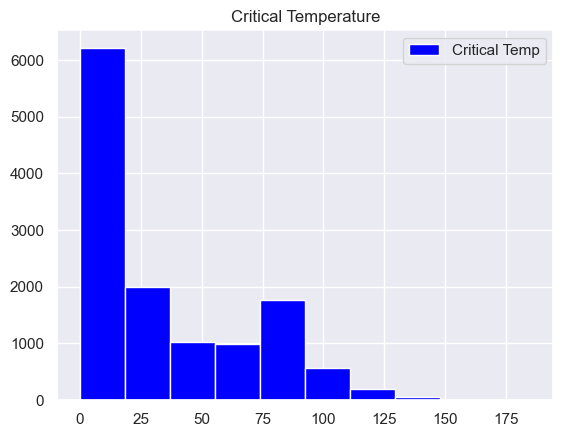

In [23]:
sns.set(font_scale=1.0)
plt.title('Critical Temperature')
plt.hist(y_train,color='blue',label='Critical Temp')
plt.legend()

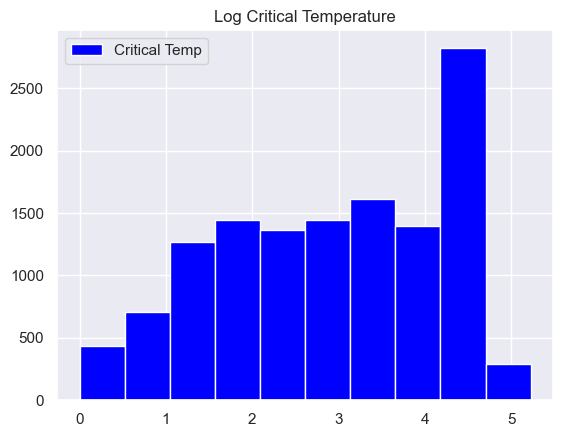

In [24]:
sns.set(font_scale=1.0)
plt.title('Log Critical Temperature')
plt.hist(np.log1p(y_train),color='blue',label='Critical Temp')
plt.legend()

In [25]:
#Stats, Variable_Explain  = Analysis(Input_Data)

In [26]:
#Stats

In [27]:
#Variable_Explain['Corr_ABS'] = Variable_Explain[['Corr']].abs().rename(columns={'Corr':'Corr_ABS'})
#Variable_Explain.sort_values(by='Corr_ABS',ascending=False)

In [28]:
X_train_all = X_train.astype('float16')
X_test_all = X_test.astype('float16')

In [29]:
X_train_all.shape,X_test_all.shape

((12759, 560), (8504, 560))

#### ML Tree Models

In [36]:
# 활용할 ML 나열 
ex = ExtraTreesRegressor(random_state=2021)
rf = RandomForestRegressor(random_state=2021)
ada = AdaBoostRegressor(random_state=2021)
gbm = GradientBoostingRegressor(random_state=2021)
hgbm = HistGradientBoostingRegressor(random_state=2021)
xgb = XGBRegressor(random_state=2021)
lgbm =  LGBMRegressor(random_state=2021)
#ngb  = NGBRegressor(random_state=2021)

models = [ex,rf,ada,gbm,hgbm,xgb,lgbm]

In [38]:
models[0].fit(X_train_all,y_train)
#models[1].fit(X_train,y_train)
#models[2].fit(X_train,y_train)
#models[3].fit(X_train,y_train)
#models[4].fit(X_train,y_train)
#models[5].fit(X_train,y_train)
#models[6].fit(X_train,y_train)

ExtraTreesRegressor(random_state=2021)

In [43]:
clf1_pred = models[0].predict(X_test_all)
pred_final = pd.DataFrame(clf1_pred).rename(columns={0:'critical_temp'})
submit_csv = pd.DataFrame(pd.concat([submission['ID'],pred_final],axis=1))
submit_csv.to_csv('submission_extratree.csv',index=False)
submit_csv

,ID,critical_temp
0,TEST_00000,1.645000
1,TEST_00001,4.638870
2,TEST_00002,12.564950
3,TEST_00003,48.542500
4,TEST_00004,3.733933
...,...,...
8499,TEST_08499,6.916000
8500,TEST_08500,24.700000
8501,TEST_08501,11.689000
8502,TEST_08502,19.085715


(array([4.013e+03, 1.381e+03, 7.140e+02, 8.350e+02, 1.169e+03, 2.590e+02,
        1.120e+02, 2.000e+01, 0.000e+00, 1.000e+00]),
 array([3.19999992e-04, 1.85002880e+01, 3.70002560e+01, 5.55002240e+01,
        7.40001920e+01, 9.25001600e+01, 1.11000128e+02, 1.29500096e+02,
        1.48000064e+02, 1.66500032e+02, 1.85000000e+02]),
 <BarContainer object of 10 artists>)

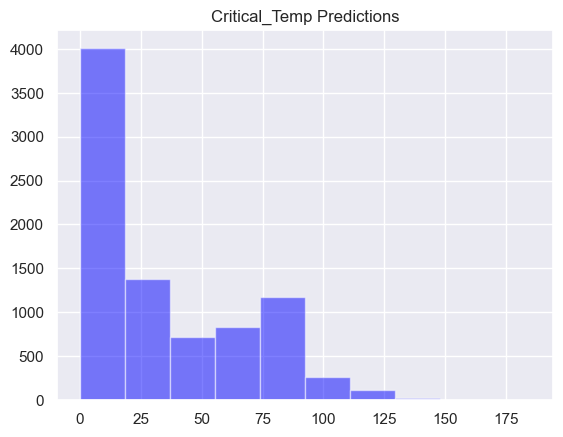

In [44]:
plt.title('Critical_Temp Predictions')
plt.hist(submit_csv['critical_temp'],color='blue',alpha=0.5)